In [1]:
import os
import xml.etree.ElementTree as ET
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np


In [2]:
import torch

# Check if PyTorch is installed
try:
    print(f"PyTorch version: {torch.__version__}")
except ImportError:
    print("PyTorch is not installed.")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

# Test a simple tensor operation
try:
    x = torch.tensor([1.0, 2.0, 3.0])
    y = torch.tensor([4.0, 5.0, 6.0])
    print("Tensor operation result:", x + y)
    print("PyTorch is working correctly.")
except Exception as e:
    print(f"An error occurred: {e}")


PyTorch version: 2.5.1+cu124
CUDA is available.
CUDA version: 12.4
Number of GPUs available: 1
Current GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Tensor operation result: tensor([5., 7., 9.])
PyTorch is working correctly.


In [25]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset


class SheepVOCDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        """
        Args:
            images_dir (str): Directory containing images.
            annotations_dir (str): Directory containing XML annotations in Pascal VOC format.
            transforms (callable, optional): Transforms to be applied on the images.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms

        # Class-to-ID mapping
        self.class_name_to_id = {
            "graze": 1,
            "sit": 2,
            "walk": 3,
            "run": 4
        }

        # Collect images and annotations
        self.image_files = [f for f in os.listdir(self.images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_files.sort()

        self.annotation_files = [f for f in os.listdir(self.annotations_dir) if f.lower().endswith('.xml')]
        self.annotation_files.sort()

        # Match images and annotations
        image_basenames = set(os.path.splitext(img)[0] for img in self.image_files)
        annot_basenames = set(os.path.splitext(ann)[0] for ann in self.annotation_files)
        common = image_basenames.intersection(annot_basenames)
        self.image_files = [img for img in self.image_files if os.path.splitext(img)[0] in common]

    def __len__(self):
        return len(self.image_files)

    def parse_voc_xml(self, xml_path):
        """
        Parses a Pascal VOC XML annotation file.

        Args:
            xml_path (str): Path to the XML annotation file.

        Returns:
            boxes (list): List of bounding boxes [xmin, ymin, xmax, ymax].
            labels (list): List of corresponding class labels.
        """
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text.lower().strip()
            if name not in self.class_name_to_id:
                continue

            label = self.class_name_to_id[name]

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample.

        Returns:
            img (Tensor): Transformed image.
            target (dict): Target dictionary containing:
                - boxes (Tensor): Bounding boxes.
                - labels (Tensor): Class labels.
                - image_id (Tensor): Image ID.
                - area (Tensor): Areas of bounding boxes.
                - iscrowd (Tensor): Crowd flags (all set to 0 for single objects).
        """
        img_name = self.image_files[idx]
        base_name = os.path.splitext(img_name)[0]

        img_path = os.path.join(self.images_dir, img_name)
        annot_path = os.path.join(self.annotations_dir, base_name + ".xml")

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(annot_path)

        # Handle cases with no annotations
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        # Generate additional metadata
        image_id = torch.tensor([idx])
        if boxes.shape[0] > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.zeros((0,), dtype=torch.float32)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transformations if defined
        if self.transforms:
            img = self.transforms(img)

        return img, target


In [26]:
from torchvision.transforms import Compose, ToTensor

# Paths
images_dir = "processed_dataset/train_images"
annotations_dir = "processed_dataset/train_annotations"

# Define transforms
transforms = Compose([
    ToTensor()
])

# Initialize dataset
dataset = SheepVOCDataset(images_dir, annotations_dir, transforms=transforms)

# Example: Fetch a sample
image, target = dataset[0]

print("Image shape:", image.shape)
print("Target:", target)


Image shape: torch.Size([3, 224, 224])
Target: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([0]), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64)}


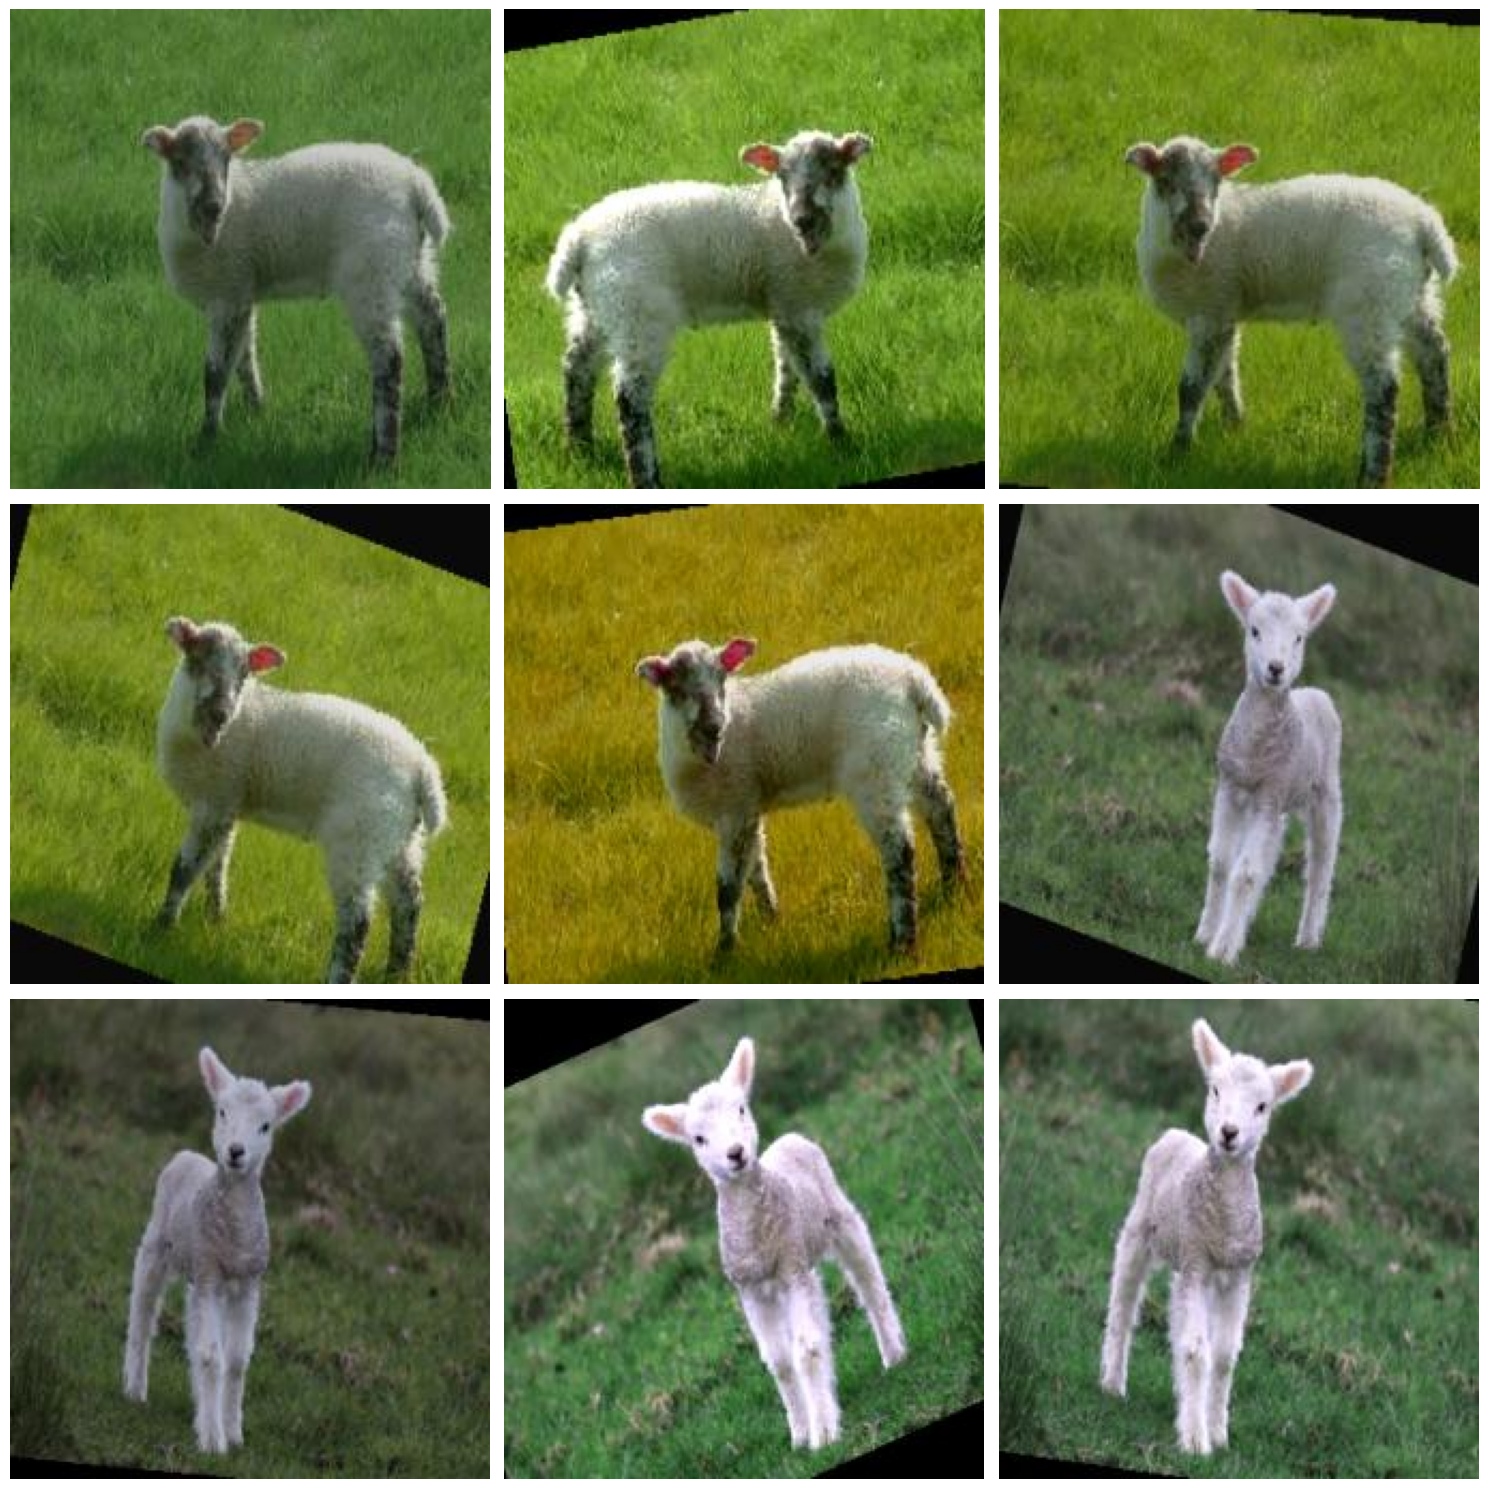

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

def visualize_dataset_samples(dataset, class_name_to_id, num_images=9):
    """
    Visualizes multiple images from the dataset with bounding boxes and labels.

    Args:
        dataset: The dataset object to sample images from.
        class_name_to_id (dict): Mapping of class names to IDs.
        num_images: Number of images to visualize (default: 9).
    """
    # Reverse the class_name_to_id mapping
    id_to_class_name = {v: k for k, v in class_name_to_id.items()}

    # Define the grid size (rows and columns)
    cols = 3
    rows = num_images // cols if num_images % cols == 0 else (num_images // cols) + 1

    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_images):
        # Get the image and target
        image, target = dataset[i]

        # Convert the tensor to a PIL image
        image = to_pil_image(image)

        # Plot the image
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')

        # Plot bounding boxes and labels
        for box, label in zip(target['boxes'], target['labels']):
            x_min, y_min, x_max, y_max = box.tolist()
            width = x_max - x_min
            height = y_max - y_min

            # Add the bounding box
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

            # Add the label with the class name
            class_name = id_to_class_name[label.item()]
            ax.text(
                x_min, y_min - 5, f"{class_name}",
                color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
            )

    # Hide unused axes if num_images < rows * cols
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
class_name_to_id = {
    "graze": 1,
    "sit": 2,
    "walk": 3,
    "run": 4
}

visualize_dataset_samples(dataset, class_name_to_id, num_images=9)


In [31]:
# Debugging the dataset
image, target = dataset[0]  # Load a sample from the dataset
print("Image shape:", image.shape)
print("Target:", target)


Image shape: torch.Size([3, 224, 224])
Target: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([0]), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64)}


In [32]:
import os
annotations_dir = "archive/annotations"
annotations = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
print(f"Number of annotations: {len(annotations)}")
print("Example annotations:", annotations[:5])


Number of annotations: 203
Example annotations: ['sheep101.xml', 'sheep76.xml', 'sheep150.xml', 'sheep201.xml', 'sheep115.xml']


In [34]:
import xml.etree.ElementTree as ET

def parse_voc_xml_debug(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text.lower().strip()
        print(f"Object name: {name}")
        
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        print(f"Bounding box: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")

        # Collect bounding boxes and labels
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(name)

    return boxes, labels

# Test with a specific annotation file
xml_path = "archive/annotations/sheep18.xml"
boxes, labels = parse_voc_xml_debug(xml_path)
print("Boxes:", boxes)
print("Labels:", labels)


Object name: sheep
Bounding box: xmin=23.0, ymin=26.0, xmax=235.0, ymax=258.0
Object name: sheep
Bounding box: xmin=286.0, ymin=69.0, xmax=390.0, ymax=211.0
Boxes: [[23.0, 26.0, 235.0, 258.0], [286.0, 69.0, 390.0, 211.0]]
Labels: ['sheep', 'sheep']


In [17]:
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import shutil
from tqdm import tqdm

# Paths
images_path = "archive/images"  # Path to images
annotations_path = "archive/annotations"  # Path to annotations
output_path = "processed_dataset"

# Directories for augmented data and final train/val splits
augmented_images_dir = os.path.join(output_path, 'augmented_images')
os.makedirs(augmented_images_dir, exist_ok=True)

train_images_dir = os.path.join(output_path, 'train_images')
train_annotations_dir = os.path.join(output_path, 'train_annotations')
val_images_dir = os.path.join(output_path, 'val_images')
val_annotations_dir = os.path.join(output_path, 'val_annotations')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_annotations_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_annotations_dir, exist_ok=True)

# Get all image file names
image_files = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))]

# Define data augmentation transforms
augmentations = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Apply augmentations to all images
for img_file in tqdm(image_files, desc="Applying Augmentations"):
    img_path = os.path.join(images_path, img_file)
    annotation_file = os.path.splitext(img_file)[0] + '.xml'
    img = Image.open(img_path).convert("RGB")

    for i in range(5):  # Generate 5 augmented images per original
        augmented_img = augmentations(img)
        augmented_img_pil = transforms.ToPILImage()(augmented_img)
        augmented_img_name = f"{os.path.splitext(img_file)[0]}_aug_{i}.jpeg"
        augmented_img_pil.save(os.path.join(augmented_images_dir, augmented_img_name))

        # Copy corresponding annotation file if it exists
        if os.path.exists(os.path.join(annotations_path, annotation_file)):
            shutil.copy(
                os.path.join(annotations_path, annotation_file),
                os.path.join(augmented_images_dir, os.path.splitext(augmented_img_name)[0] + '.xml')
            )

# Split augmented data into training and validation sets
augmented_image_files = [f for f in os.listdir(augmented_images_dir) if f.endswith('.jpeg')]
train_files, val_files = train_test_split(augmented_image_files, test_size=0.2, random_state=42)

# Move files to respective directories
for file in train_files:
    shutil.copy(os.path.join(augmented_images_dir, file), os.path.join(train_images_dir, file))
    annotation_file = os.path.splitext(file)[0] + '.xml'
    if os.path.exists(os.path.join(augmented_images_dir, annotation_file)):
        shutil.copy(os.path.join(augmented_images_dir, annotation_file), os.path.join(train_annotations_dir, annotation_file))

for file in val_files:
    shutil.copy(os.path.join(augmented_images_dir, file), os.path.join(val_images_dir, file))
    annotation_file = os.path.splitext(file)[0] + '.xml'
    if os.path.exists(os.path.join(augmented_images_dir, annotation_file)):
        shutil.copy(os.path.join(augmented_images_dir, annotation_file), os.path.join(val_annotations_dir, annotation_file))

# Output summary
print("Train images directory:", train_images_dir)
print("Train annotations directory:", train_annotations_dir)
print("Validation images directory:", val_images_dir)
print("Validation annotations directory:", val_annotations_dir)
print("Number of training images:", len(os.listdir(train_images_dir)))
print("Number of training annotations:", len(os.listdir(train_annotations_dir)))
print("Number of validation images:", len(os.listdir(val_images_dir)))
print("Number of validation annotations:", len(os.listdir(val_annotations_dir)))


Applying Augmentations: 100%|██████████| 203/203 [00:09<00:00, 22.42it/s]


Train images directory: processed_dataset/train_images
Train annotations directory: processed_dataset/train_annotations
Validation images directory: processed_dataset/val_images
Validation annotations directory: processed_dataset/val_annotations
Number of training images: 812
Number of training annotations: 812
Number of validation images: 203
Number of validation annotations: 203


In [18]:

train_images_dir = "processed_dataset/augmented_images"
train_annotations_dir = "processed_dataset/train_annotations"

val_images_dir = "processed_dataset/val_images"
val_annotations_dir = "processed_dataset/val_annotations"


 
train_transforms = T.Compose([T.ToTensor()])
val_transforms = T.Compose([T.ToTensor()])

train_dataset = SheepVOCDataset(train_images_dir, train_annotations_dir, transforms=train_transforms)
val_dataset = SheepVOCDataset(val_images_dir, val_annotations_dir, transforms=val_transforms)

 
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [20]:
def get_model(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


num_classes = 5
model = get_model(num_classes)


/home/zahoor-ai-developer/Desktop/Project#3/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zahoor-ai-developer/Desktop/Project#3/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/zahoor-ai-developer/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [23]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {losses.item():.4f}")
        i += 1

   
    lr_scheduler.step()

  


Epoch [0/2], Step [0/406], Loss: 0.0022
Epoch [0/2], Step [10/406], Loss: 0.0023
Epoch [0/2], Step [20/406], Loss: 0.0009
Epoch [0/2], Step [30/406], Loss: 0.0019
Epoch [0/2], Step [40/406], Loss: 0.0036
Epoch [0/2], Step [50/406], Loss: 0.0017
Epoch [0/2], Step [60/406], Loss: 0.0031
Epoch [0/2], Step [70/406], Loss: 0.0010
Epoch [0/2], Step [80/406], Loss: 0.0008
Epoch [0/2], Step [90/406], Loss: 0.0018
Epoch [0/2], Step [100/406], Loss: 0.0022
Epoch [0/2], Step [110/406], Loss: 0.0014
Epoch [0/2], Step [120/406], Loss: 0.0012
Epoch [0/2], Step [130/406], Loss: 0.0018
Epoch [0/2], Step [140/406], Loss: 0.0000
Epoch [0/2], Step [150/406], Loss: 0.0014
Epoch [0/2], Step [160/406], Loss: 0.0006
Epoch [0/2], Step [170/406], Loss: 0.0015
Epoch [0/2], Step [180/406], Loss: 0.0012
Epoch [0/2], Step [190/406], Loss: 0.0010
Epoch [0/2], Step [200/406], Loss: 0.0015
Epoch [0/2], Step [210/406], Loss: 0.0011
Epoch [0/2], Step [220/406], Loss: 0.0015
Epoch [0/2], Step [230/406], Loss: 0.0015
Epo

In [24]:
model.eval()
images, targets = next(iter(val_loader))
images = list(img.to(device) for img in images)
outputs = model(images)

print(outputs)


[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}, {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]
